In [1]:
import redis
import json
from textblob import Word
import re
import nltk
from nltk.corpus import stopwords
import contractions
import string
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import AffinityPropagation
import distance

redis connection

In [2]:
r = redis.Redis(host='redis-12442.c90.us-east-1-3.ec2.cloud.redislabs.com',port=12442,password='RHFgwK2pQ2ibFUqw8zrQBHRzK29lQtDw')
keys=r.keys('*') #getting the keys of each convesation
print(len(keys))

99


grouping all intents together as a dictionary

In [3]:
trackerdata=[]
for i in keys: 
    temp=r[i]
    temp = temp.decode("utf-8")
    trackerdata.append(json.loads(temp)) #each conversation is saved with its events as a list and trackername
conversations=[]
for i in trackerdata:
    conversations.append(i["events"]) #extracting only the events list of each conversation
intents=set()
intentdictnew=dict()
for conv in conversations:
    for i in conv:# extracting the intents from the conversations
        if i['event']=="user":
            if i['parse_data']['intent']['name'] not in intents:
                intents.add(i['parse_data']['intent']['name'])
                intentdictnew[i['parse_data']['intent']['name']]={i["text"]}
            else:
                intentdictnew[i['parse_data']['intent']['name']].add(i["text"])
for k,v in intentdictnew.items():
    print(k,":",v)



price_details : {'i want the item details', '/price_details', 'price details', 'price detaisl', 'price detaosl'}
get_item_prices : {'item ifno', '/get_item_prices'}
get_specific_price : {'particular item particular location', 'cost of particular item', '/get_specific_price'}
item_details : {'100140000', 'what is 4-5-4 calender?', '100150000', 'it is 607', '1000350001', '100035001', '105', 'the number is 100150000', 'what is 454 calender in retail?', 'give adhipursh review', '246001', 'loc is 246001', '607', 'what is 454 calendar?', '10035001', '100140001', '100185305'}
location_details : {'location 246001', 'location 607', 'price details for location 607', 'loc is 607', 'location 105', 'loc 607'}
hello : {'/hello'}
continue_info : {'yes', 'RMS'}
get_item_all_locs : {'UPC in RMS', '/get_item_all_locs', 'cost of all items in particular location'}
deny : {'', 'what is vendor', 'i want the trichy weather', 'no', 'vendor', '/stop'}
greet : {"how's the weather like", 'adipurush review', 'how

DESCRIPTIVE ANALYSIS OF UNRECOGNISED USER INPUTS

In [4]:
newinputs=intentdictnew["nlu_fallback"] | intentdictnew["others"]
print(newinputs)

{'hwta is UPC', 'list IT companies in chennai', 'what is UPC', 'how is the weather like', '/others', 'i want the iem details', 'what is the weather in trichy', 'who is the cheoif minister of tamilnadu', '100150000', 'what is the climate', 'what is the weather', 'who is vendor', 'loc is 607', '100035001', 'how is the climate', 'list IT companies chennai', 'what is replenishment ?', '/action_get_item_prices', 'what is the wetaher like', 'what is RMS', 'list states in tamilnadu', 'how is the climate like', 'prime minister of india', 'what is the weather in chennai', 'UPC in retail', 'who is the cheif minister of tamilnadu', 'what is Stock Ledger in retail domain', 'rasa', 'UPC', 'president of india', 'list states in india', '607', 'what is the weather condition in trichy', 'upc oracle', 'what is python', 'cheif minister of tamilnadu', 'hows the weather like in chennai', 'what is RASA', 'what is the weather in madurai', 'what is the weather like', 'what is climatic change', 'prime minister

PREPROCESSING THE DATA

In [11]:
#removing button inputs
newinputs2=set()
for i in newinputs:
    if i[0]!='/':
        newinputs2.add(i.lower())
newinputs2=list(newinputs2)
print(newinputs2)

['what is climatic change', 'i want the iem details', 'what is the weather in trichy', 'who is the cheoif minister of tamilnadu', '100150000', 'what is the climate', 'what is the weather', 'who is vendor', 'loc is 607', '100035001', 'how is the climate', 'what is stock ledger in retail domain', 'what is replenishment ?', 'what is the wetaher like', 'list states in tamilnadu', 'hwta is upc', 'upc', 'how is the climate like', 'prime minister of india', 'upc in retail', 'what is the weather in chennai', 'who is the cheif minister of tamilnadu', 'what is rasa', 'rasa', 'president of india', 'list it companies chennai', 'list states in india', '607', 'what is rms', 'what is the weather condition in trichy', 'upc oracle', 'what is python', 'cheif minister of tamilnadu', 'hows the weather like in chennai', 'what is the weather in madurai', 'what is upc', 'what is the weather like', 'how is the weather like', 'prime minister of tamilnadu', 'list it companies in chennai']


In [5]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [6]:
def cleaning_contractions(text):
    text=text.split()
    corrected=[]
    for word in text:
        corrected.append(contractions.fix(word))
    return " ".join(corrected)

In [7]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    return re.sub(re.compile("["+punctuations_list+"‼️’]")," ",text)

In [8]:
#nltk.download('stopwords')
stop_words = stopwords.words('english')
def cleaning_stopwords(data):
    words = data.split()
    filtered_words = [word for word in words if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [9]:
def correct_word_spelling(sentence):
    words=sentence.split()
    words2=[]
    for word in words:
        word = Word(word)
        words2.append(word.correct())
    return(" ".join(words2))

In [12]:
#performing all data cleaning operations

cleanedinputs=[]# stores the cleaned data
wordmap=dict()
for i in newinputs2:
    temp=cleaning_numbers(i)
    temp=cleaning_contractions(temp)
    #temp=correct_word_spelling(temp)
    temp=cleaning_punctuations(temp)
    temp=cleaning_stopwords(temp)
    if temp!="":
        cleanedinputs.append(temp)
        keys=set(wordmap.keys())
        for j in temp.split():
            if j not in keys:
                wordmap[j]=[i]
            else:
                wordmap[j].append(i) #mapping the maps to their sentences


wordmap: a dictionary that maps the word to a set of the sentences it is present in

In [13]:
for k,v in wordmap.items():
    print(k,":",v)

climatic : ['what is climatic change']
change : ['what is climatic change']
want : ['i want the iem details']
iem : ['i want the iem details']
details : ['i want the iem details']
weather : ['what is the weather in trichy', 'what is the weather', 'what is the weather in chennai', 'what is the weather condition in trichy', 'hows the weather like in chennai', 'what is the weather in madurai', 'what is the weather like', 'how is the weather like']
trichy : ['what is the weather in trichy', 'what is the weather condition in trichy']
cheoif : ['who is the cheoif minister of tamilnadu']
minister : ['who is the cheoif minister of tamilnadu', 'prime minister of india', 'who is the cheif minister of tamilnadu', 'cheif minister of tamilnadu', 'prime minister of tamilnadu']
tamilnadu : ['who is the cheoif minister of tamilnadu', 'list states in tamilnadu', 'who is the cheif minister of tamilnadu', 'cheif minister of tamilnadu', 'prime minister of tamilnadu']
climate : ['what is the climate', 'how

wordcount: mapping words to their count 

In [14]:
words=[]
for i in cleanedinputs:
    words.extend(i.split())
#print(words)
wordcount=Counter(words) #counting occurance of each word using counter class
print(wordcount)
#for k,v in wordcount.items():
#    print (k,":",v)

Counter({'weather': 8, 'minister': 5, 'tamilnadu': 5, 'like': 5, 'upc': 5, 'list': 4, 'chennai': 4, 'climate': 3, 'india': 3, 'trichy': 2, 'retail': 2, 'states': 2, 'prime': 2, 'cheif': 2, 'rasa': 2, 'companies': 2, 'climatic': 1, 'change': 1, 'want': 1, 'iem': 1, 'details': 1, 'cheoif': 1, 'vendor': 1, 'loc': 1, 'stock': 1, 'ledger': 1, 'domain': 1, 'replenishment': 1, 'wetaher': 1, 'hwta': 1, 'president': 1, 'rms': 1, 'condition': 1, 'oracle': 1, 'python': 1, 'madurai': 1})


wordcloud visualisation

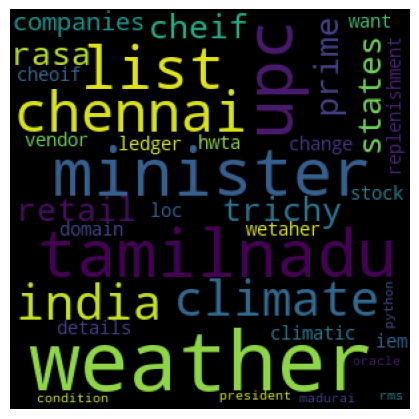

In [16]:
comment_words = " ".join(words)+ " "
#print(comment_words)
wordcloud = WordCloud(width = 300, height = 300,background_color ='black',min_font_size = 10).generate(comment_words)
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


AFFINITY PROPOGATION CLUSTERING using levenshtein distance metric

In [19]:
words = np.asarray(words) #So that indexing with a list will work
lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in words] for w2 in words])

affprop = AffinityPropagation(affinity="precomputed")
affprop.fit(lev_similarity)

clusters=dict()#stores the cluster label and the values

for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]] #the clusterlabel
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)]).tolist() #cluster values
    count=[wordcount[i] for i in cluster]
    totalcount=sum(count)
    d=dict() # creating a dictionary with key as clusterlabel, values as the totalcount,the cluster words and their indivial count
    d['total_count']=totalcount
    d['words']=cluster
    d['word count']=count
    clusters[exemplar]=d

for k,v in clusters.items():
    print(k,":")
    for k1,v1 in v.items():
        print("\t",k1,":",v1)

# you can access the sentence the words are present in using wordmap 
#eg.  wordmap[clusters["companies"]["words"][0]]  will give all sentences in which the word companies is present

climate :
	 total_count : 4
	 words : ['climate', 'climatic']
	 word count : [3, 1]
retail :
	 total_count : 5
	 words : ['details', 'domain', 'python', 'retail']
	 word count : [1, 1, 1, 2]
replenishment :
	 total_count : 1
	 words : ['replenishment']
	 word count : [1]
list :
	 total_count : 5
	 words : ['list', 'want']
	 word count : [4, 1]
states :
	 total_count : 3
	 words : ['states', 'stock']
	 word count : [2, 1]
tamilnadu :
	 total_count : 5
	 words : ['tamilnadu']
	 word count : [5]
upc :
	 total_count : 6
	 words : ['loc', 'upc']
	 word count : [1, 5]
minister :
	 total_count : 5
	 words : ['minister']
	 word count : [5]
india :
	 total_count : 4
	 words : ['india', 'vendor']
	 word count : [3, 1]
cheif :
	 total_count : 3
	 words : ['cheif', 'cheoif']
	 word count : [2, 1]
rasa :
	 total_count : 5
	 words : ['hwta', 'madurai', 'rasa', 'rms']
	 word count : [1, 1, 2, 1]
companies :
	 total_count : 3
	 words : ['companies', 'condition']
	 word count : [2, 1]
chennai :
	 total

sorting the clusters in descending

In [20]:
clusters = sorted(clusters.items(), key=lambda x:x[1]["total_count"],reverse=True)
clusters=dict(clusters)
for k,v in clusters.items():
    print(k,":")
    for k1,v1 in v.items():
        print("\t",k1,":",v1)

weather :
	 total_count : 9
	 words : ['weather', 'wetaher']
	 word count : [8, 1]
like :
	 total_count : 7
	 words : ['iem', 'ledger', 'like']
	 word count : [1, 1, 5]
upc :
	 total_count : 6
	 words : ['loc', 'upc']
	 word count : [1, 5]
retail :
	 total_count : 5
	 words : ['details', 'domain', 'python', 'retail']
	 word count : [1, 1, 1, 2]
list :
	 total_count : 5
	 words : ['list', 'want']
	 word count : [4, 1]
tamilnadu :
	 total_count : 5
	 words : ['tamilnadu']
	 word count : [5]
minister :
	 total_count : 5
	 words : ['minister']
	 word count : [5]
rasa :
	 total_count : 5
	 words : ['hwta', 'madurai', 'rasa', 'rms']
	 word count : [1, 1, 2, 1]
chennai :
	 total_count : 5
	 words : ['change', 'chennai']
	 word count : [1, 4]
climate :
	 total_count : 4
	 words : ['climate', 'climatic']
	 word count : [3, 1]
india :
	 total_count : 4
	 words : ['india', 'vendor']
	 word count : [3, 1]
states :
	 total_count : 3
	 words : ['states', 'stock']
	 word count : [2, 1]
cheif :
	 tota

extracting words from the top clusters and their sentences

In [21]:
N=5
top_cluster_keys=list(clusters.keys())[:N]
print(top_cluster_keys)

['weather', 'like', 'upc', 'retail', 'list']


In [22]:
#using clusters, wordmap and wordcount
for i in top_cluster_keys:
    words=clusters[i]["words"]
    tc=clusters[i]["total_count"]
    print(i+"("+str(tc)+")",":")
    for word in words:
        print("\t",word+"("+str(wordcount[word])+")",":")
        for phrase in wordmap[word]:
            print("\t\t",phrase)

weather(9) :
	 weather(8) :
		 what is the weather in trichy
		 what is the weather
		 what is the weather in chennai
		 what is the weather condition in trichy
		 hows the weather like in chennai
		 what is the weather in madurai
		 what is the weather like
		 how is the weather like
	 wetaher(1) :
		 what is the wetaher like
like(7) :
	 iem(1) :
		 i want the iem details
	 ledger(1) :
		 what is stock ledger in retail domain
	 like(5) :
		 what is the wetaher like
		 how is the climate like
		 hows the weather like in chennai
		 what is the weather like
		 how is the weather like
upc(6) :
	 loc(1) :
		 loc is 607
	 upc(5) :
		 hwta is upc
		 upc
		 upc in retail
		 upc oracle
		 what is upc
retail(5) :
	 details(1) :
		 i want the iem details
	 domain(1) :
		 what is stock ledger in retail domain
	 python(1) :
		 what is python
	 retail(2) :
		 what is stock ledger in retail domain
		 upc in retail
list(5) :
	 list(4) :
		 list states in tamilnadu
		 list it companies chennai
		 list

deleting all keys after performing the analysis (RUN THIS ONLY IF YOU WANT TO CLEAR THE DATABASE)

In [ ]:
# will delete all keys in the database 

for key in keys:
    r.delete(key) 